In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk


In [30]:
search = lk.search_lightcurve('TOI 700',mission='TESS',sector=1)
lc = search.download()

/Users/Dhruv/Desktop/expoplanet_detection/.venv/lib/python3.14/site-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 9 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

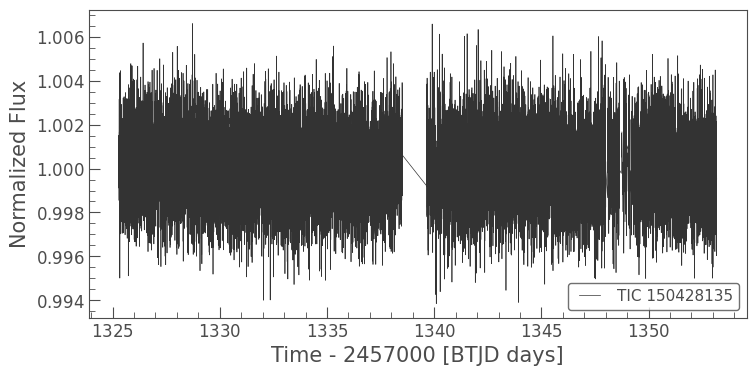

In [31]:
lc = lc.remove_nans().remove_outliers().normalize() #normalize 
lc.plot()

In [32]:
flattend_lc = lc.flatten(window_length=401) #flattens the light curve to remove long- term trends like stellar variability
flattend_lc.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [33]:
periodogram = flattend_lc.to_periodogram(method='bls') #finds periodic signals using Box Least Squares (find repeating dips in brightness)
periodogram.plot()

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

In [34]:
best_period = periodogram.period_at_max_power #get the period with the highest power (most likely to be the planet's orbital period)
transit_time = periodogram.transit_time_at_max_power #get the time of transit corresponding to the best period
duration =periodogram.duration_at_max_power #get the duration of the transit


In [35]:
fold = flattend_lc.fold(period=best_period,epoch_time=transit_time) #fold the light curve on the best period to align all transits

In [36]:
flux= fold.flux.value 
time = fold.time.value
depth = 1-np.min(flux)

snr= depth/np.std(flux)

print(flux)
print(time)
print(depth)
print(snr)

[1.00066835 1.00067696 1.00029215 ... 0.99898002 1.00083281 0.99928002]
[-0.16611215 -0.16611129 -0.1661043  ...  0.16607767  0.16609215
  0.1661097 ]
0.006232118461980907
3.7828018923616433


In [37]:
ax = fold.plot()
plt.savefig('folded_lightcurve_plot.png')

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# X = [[best_period,depth,duration.value,snr]]
# y = [1]

# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# model= RandomForestClassifier()
# model.fit(x_train,y_train)
# pred = model.predict(x_test)


X = [[best_period.value, depth, duration.value, snr]] * 5 
y = [1] * 5

# Add a negative sample to make it a valid classification task
X.append([0.5, 0.001, 0.1, 1.0])
y.append(0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)

print(accuracy_score(y_test, pred))




1.0
